<a href="https://colab.research.google.com/github/iampro3/YOLOv7/blob/main/Train_YOLOv7_with_Pascal_VOC_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 Colab에서 YOLOv7-tiny 모델을 VOC dataset으로 훈련하는 예제입니다.

PASCAL VOC Dataset을 다운로드 받은 후 압축을 풀어줍니다.

In [1]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar

--2023-12-06 08:50:47--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2023-12-06 08:50:47--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  26.2MB/s    in 74s     

2023-12-06 08:52:02 (25.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



실습하고 있는 데이터셋은 라벨링이 xml 파일 포맷으로 제공되며, 해당 포맷은 YOLOv7을 활용해 객체 인식 신경망을 훈련할 때 사용할 수 있는 파일 포맷이 아닙니다.

convert2Yolo라고 하는 깃허브 저장소에서 Pascal VOC 데이터셋의 xml 파일 형태를 YOLOv7를 통한 훈련에 사용할 수 있도록 변환하는 기능을 제공합니다. 이를 활용해 xml 파일 포맷을 txt 파일 포맷으로 변환하겠습니다.

이 과정에 앞서 다음과 같이 Pascal VOC 데이터셋의 클래스 리스트가 있는 파일을 생성합니다.

In [2]:
classes = ["aeroplane\n", "bicycle\n", "bird\n", "boat\n", "bottle\n",
           "bus\n", "car\n", "cat\n", "chair\n", "cow\n", "diningtable\n",
           "dog\n", "horse\n", "motorbike\n", "person\n", "pottedplant\n",
           "sheep\n", "sofa\n", "train\n", "tvmonitor"]
with open("vocnames.txt", 'w') as f:
    f.writelines(classes)

vocnames.txt 파일이 생성된 것을 확인한 후 다음과 같이 VOCdevkit/VOC2012 폴더 아래에 labels 폴더를 생성한 후 convert2Yolo 저장소를 활용해 xml 파일을 txt 파일로 변환합니다

In [3]:
!git clone https://github.com/ssaru/convert2Yolo.git
!cd convert2Yolo && python3 example.py --datasets VOC \
--img_path ../VOCdevkit/VOC2012/JPEGImages/ \
--label ../VOCdevkit/VOC2012/Annotations/ \
--convert_output_path ../VOCdevkit/VOC2012/JPEGImages/ \
--img_type ".jpg" \
--manifest_path ../ \
--cls_list_file ../vocnames.txt

Cloning into 'convert2Yolo'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 38), reused 35 (delta 35), pack-reused 172
Receiving objects: 100% (215/215), 994.67 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (95/95), done.

VOC Parsing:   |████████████████████████████████████████| 100.0% (17125/17125)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (17125/17125)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (17125/17125)  Complete



다운로드 완료 후 훈련을 위한 이미지가 있는 폴더의 경로는 아래와 같습니다.

/content/VOCdevkit/VOC2012/JPEGImages/

YOLOv7를 통한 객체 인식 신경망을 훈련하기 위해 각 이미지 내 객체의 위치가 라벨링되어 있는 텍스트 파일은 이미지와 같은 폴더에 있습니다.

YOLOv7에서 훈련할 때 이미지와 같은 경로에 이미지와 동일한 이름의 라벨링 된 텍스트 파일이 있어야만 훈련을 수행할 수 있습니다. 구체적인 파일 구조는 아래와 같습니다.


```
$Object_Detection_Dataset/
                         ┗ 1.png
                         ┗ 1.txt
                         ┗ 2.jpg
                         ┗ 2.txt

```

이제 데이터를 훈련 데이터와 검증 데이터로 나누겠습니다.

In [4]:
import os
import shutil
from tqdm import tqdm
data_root = "/content/VOCData"
val_root = os.path.join(data_root, "val")
train_root = os.path.join(data_root, "train")
os.makedirs(val_root, exist_ok=True)
os.makedirs(train_root, exist_ok=True)

with open("/content/manifest.txt") as f:
    files = f.readlines()

for idx, img_path in tqdm(enumerate(files)):
    img_src = img_path.split('\n')[0]
    txt_src = os.path.splitext(img_src)[0] + ".txt"
    img_name = os.path.split(img_src)[-1]
    text_name = os.path.split(txt_src)[-1]
    if idx % 10 < 3:
        img_dst = os.path.join(val_root, img_name)
        text_dst = os.path.join(val_root, text_name)
    else:
        img_dst = os.path.join(train_root, img_name)
        text_dst = os.path.join(train_root, text_name)
    shutil.copy2(img_src, img_dst)
    shutil.copy2(txt_src, text_dst)

17125it [00:04, 3474.58it/s]


이제 YOLOv7-tiny를 VOC dataset으로 훈련하도록 하겠습니다.

학습을 위해 YOLOv7 환경을 구성하도록 하겠습니다.

In [5]:
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
%pip install -qr requirements.txt  # install

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1197 (delta 2), reused 3 (delta 1), pack-reused 1191
Receiving objects: 100% (1197/1197), 74.23 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (517/517), done.
/content/yolov7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00




```
# 코드로 형식 지정됨
```

훈련에 앞서 YOLOv5로 추론을 할 수 있는 환경인지 테스트해봅니다.

검출은 아래와 같은 방식으로 할 수 있습니다.
```
python detect.py --source 0  # webcam
                          img.jpg  # image
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

아래의 스크립트가 에러 없이 수행된다면 훈련할 준비가 되었습니다.

Namespace(weights=['yolov7-tiny.pt'], source='inference/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.1.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

100% 12.1M/12.1M [00:00<00:00, 36.8MB/s]

Fusing layers... 
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 200 layers, 6219709 parameters, 229245 gradients, 13.7 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

4 persons, 1 bus, Done. (5.2ms) Inference, (38.7ms) NMS
 The image with t

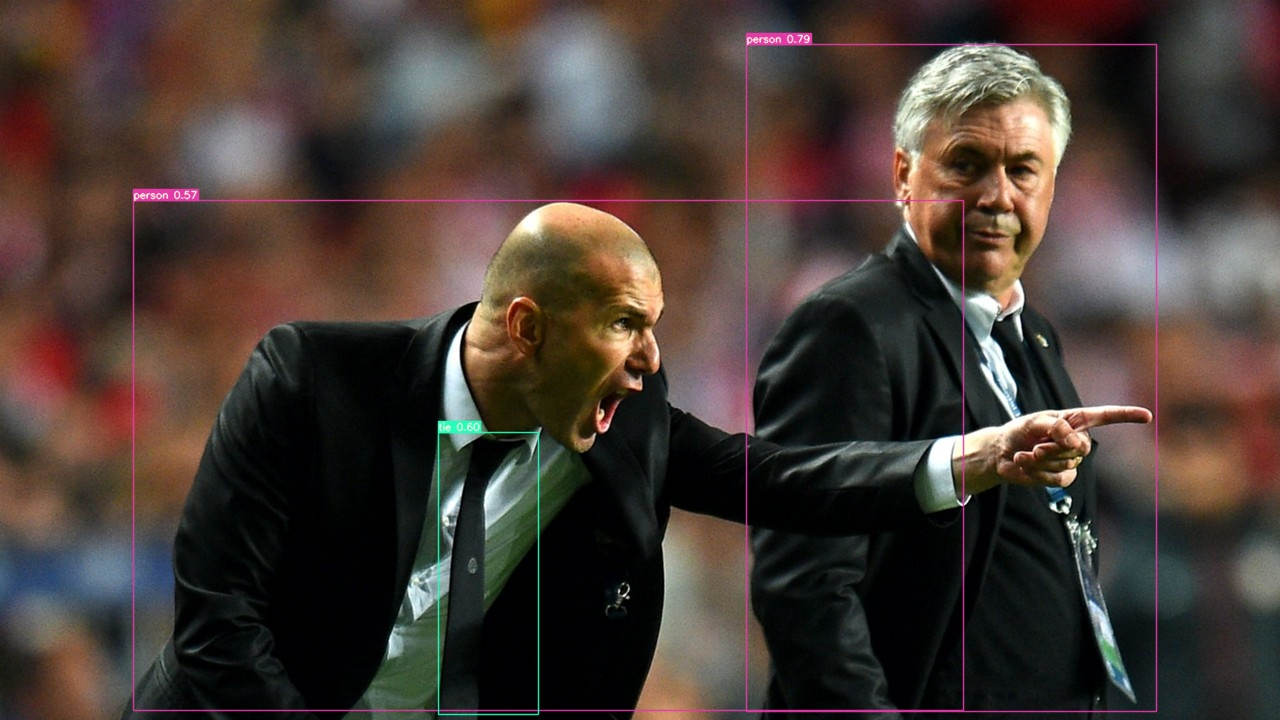

In [6]:
!python detect.py --weights yolov7-tiny.pt --img 640 --conf 0.25 --source inference/images
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread('runs/detect/exp/zidane.jpg'))

이제 훈련을 위한 설정 파일을 준비합니다.
내용은 아래와 같습니다.

YOLOv7는 darknet을 사용하는 이전의 YOLOv4와는 다르게 데이터셋이 있는 폴더 경로를 입력하여서 훈련에 사용할 수 있습니다.

```
train:  /content/VOCData/train
val:  /content/VOCData/val

# number of classes
nc: 20

# class names
names: [ 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
         'sheep', 'sofa', 'train', 'tvmonitor' ]
```


In [7]:
text_lines = '''
train:  /content/VOCData/train
val:  /content/VOCData/val

# number of classes
nc: 20

# class names
names: [ 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
         'sheep', 'sofa', 'train', 'tvmonitor' ]
'''
with open("/content/yolov7/vocdata.yaml", 'w') as f:
    f.write(text_lines)

이제 훈련을 수행하겠습니다.

In [8]:
!python train.py --img 320 --batch 8 --epochs 20 --data vocdata.yaml --weights yolov7-tiny.pt --cache

2023-12-06 08:54:46.091928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 08:54:46.091980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 08:54:46.092006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 08:54:46.099802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 08:54:47.059105: W tensorflow/compiler/

훈련이 완료되면 weight 파일을 다운로드합니다.

In [9]:
from google.colab import files
files.download('/content/yolov7/runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>